<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TS3: Análisis de Fourier: FFT, desparramo, interpolación y ventaneo 

**Alumna:** Agustina Rocío Paolini Rosso  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Septiembre 2025  

## Consigna
Generar una señal senoidal de frecuencia:  
$$
f_0 = k_0 \cdot \frac{f_S}{N} = k_0 \cdot \Delta f
$$
con potencia normalizada (energía o varianza unitaria). 

1. Variar $k_0$ como:
    - $k_0 = \frac{N}{4}$
    - $k_0 = \frac{N}{4} + 0.25$
    - $k_0 = \frac{N}{4} + 0.5$
   
Graficar las densidades espectrales de potencia (PSD) de las tres señales y discutir el efecto de la desintonía respecto a $\Delta f$ en el espectro visualizado.

2. Utilizando la identidad de Parseval, comparar y verificar que la potencia de cada PSD sea unitaria. Explicar por qué una senoidal ligeramente desintonizada tiene un espectro tan distinto respecto a otra perfectamente alineada con $\Delta f$.
    
3. Aplicar *zero padding* para aumentar la resolución en frecuencia utilizando un vector de $9 \cdot N$ ceros y repetir los experimentos. 

4. *Bonus*:   
    - Calcular la respuesta en frecuencia de los sistemas LTI de la TS2. 

## Introducción teórica

En el presente trabajo se estudia el fenómeno del desparramo espectral que aparece al calcular la **Transformada Discreta de Fourier (DFT)**. Esta herramienta resulta fundamental para el análisis de señales digitales, ya que permite representar una señal periódica de longitud finita $N$ como una combinación de sinusoidales complejas.  

$$
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-j 2 \pi \frac{k}{N} n}, \quad k = 0,1,\dots,N-1 \tag{1}
$$

donde $x[n]$ es la señal en el dominio temporal y $e^{-j 2 \pi k n / N}$ son las bases complejas sobre las cuales se proyecta la señal.  
Cada coeficiente $X[k]$ indica cuánto de la frecuencia $f_k = k \cdot \Delta f$ está presente en la señal $x[n]$, transformando así la señal del dominio temporal al dominio frecuencial discreto.

Dado que en la práctica siempre se trabaja con un número finito de muestras, la DFT introduce una discretización en frecuencia, en la que la separación entre bins está dada por:

$$
\Delta f = \frac{f_s}{N}
$$

donde $f_s$ es la frecuencia de muestreo.  

Cuando la frecuencia de la señal de entrada coincide exactamente con un múltiplo de $\Delta f$, toda la energía se concentra en un único bin de la DFT. En cambio, cuando la frecuencia no está alineada con los bins, se produce el **desparramo espectral (spectral leakage)**: la energía se distribuye en varios coeficientes y aparecen lóbulos laterales, lo que distorsiona la visualización del espectro.

En este contexto, resulta fundamental introducir el concepto de **Densidad Espectral de Potencia (PSD, Power Spectral Density)**, que describe cómo se distribuye la potencia de una señal en función de la frecuencia. En la práctica, la PSD puede estimarse a partir de la DFT como el módulo al cuadrado de la transformada, adecuadamente normalizado: 

$$
PSD [k] = \frac{1}{N} |X[k]|^2 \tag{2}
$$

Así, mientras que una sinusoidal pura concentra su potencia en un único bin, una mínima desintonía respecto a $\Delta f$ provoca que la potencia se reparta en frecuencias vecinas, haciendo visible el fenómeno de leakage.

Para poder comparar los resultados en el dominio de la frecuencia de manera consistente, es necesario normalizar las señales en potencia, trabajando con senoidales de varianza unitaria. Esta condición se justifica a partir de la **identidad de Parseval**, que establece la equivalencia de energía entre los dominios temporal y frecuencial:

$$
\sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2 \tag{3}
$$

De este modo, se puede verificar que la DFT conserva la energía de la señal original.

Otro aspecto relevante en este análisis es la técnica de **zero padding**, que consiste en extender la señal original agregando muestras nulas antes de aplicar la DFT. Aunque este procedimiento no modifica la energía de la señal, sí incrementa el número de puntos en el espectro, disminuyendo $\Delta f$ y, por lo tanto, ofreciendo una mayor resolución en frecuencia. Esto permite observar con más detalle la forma de los lóbulos y los efectos del leakage.

Finalmente, además del análisis espectral de señales individuales, se considera la caracterización de sistemas lineales e invariantes en el tiempo (LTI) mediante su **respuesta en frecuencia**:

$$
H(e^{j\omega}) = \frac{Y(e^{j\omega})}{X(e^{j\omega})} \tag{4}
$$

Esta respuesta describe cómo el sistema altera la magnitud y la fase de cada componente senoidal de entrada. En este trabajo se retoman ejemplos de sistemas LTI descriptos por ecuaciones en diferencias (estudiados previamente en la TS2), y se emplea la herramienta `freqz` para obtener y graficar sus respuestas en magnitud y fase.

En síntesis, el objetivo principal de este trabajo es analizar el efecto del desparramo espectral en señales sinusoidales según su alineación respecto a los bins de la DFT, verificar experimentalmente el teorema de Parseval en señales normalizadas en potencia, y estudiar cómo el zero padding mejora la visualización del espectro. Posteriormente, se extiende este análisis al ámbito de sistemas LTI, observando de qué manera procesan las distintas componentes frecuenciales de una señal.

---

## Análisis y desarrollo

En primer lugar, se generaron tres señales sinusoidales con la misma cantidad de muestras `N = 1000` y una frecuencia de muestreo de `fs = 1000 1/s`, pero con frecuencias:  

- $f_1 = \frac{N}{4} \cdot \Delta f$, alineada con un bin,  
- $f_2 = \left(\frac{N}{4} + 0.25\right) \cdot \Delta f$, desplazada 1/4 de bin,  
- $f_3 = \left(\frac{N}{4} + 0.5\right) \cdot \Delta f$, desplazada medio bin.  

In [15]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import freqz

def funcion_sen(ff, nn, amp=1, dc=0, ph=0, fs=2):
    ts = 1 / fs
    tt = np.arange(nn) * ts
    xx = amp * np.sin(2 * np.pi * ff * tt + ph) + dc
    return tt, xx


fs = 1000             # frecuencia de muestreo [1/s]
N = fs                # cantidad de muestras = 1000
delta_f = fs / N      # resolución en frecuencia

#Frecuencias pedidas por la consigna
f1 = N / 4                    # k0 = N/4 (f0 exacta en un bin)
f2 = (N / 4 + 0.25) * delta_f #desintonía 0.25 Δf
f3 = (N / 4 + 0.5) * delta_f  #desintonía 0.5 Δf

# ----------- Señales en tiempo -----------
#amplitud = sqrt(2) para que la potencia sea unitaria
tt, x1 = funcion_sen(f1, N, amp=np.sqrt(2), fs=fs)
tt, x2 = funcion_sen(f2, N, amp=np.sqrt(2), fs=fs)
tt, x3 = funcion_sen(f3, N, amp=np.sqrt(2), fs=fs)

Recordando que para una señal sinusoidal su potencia está dada por

$$
P = \frac{A^2}{2} \tag{5}
$$

se tomó como amplitud `amp = sqrt(2)` para las tres señales generadas, con el fin de que su potencia sea unitaria. 

Luego, se calculó la DFT de las tres señales mediante la **Transformada Rápida de Fourier (FFT, Fast Fourier Transform)**, un algoritmo eficiente que descompone cualquier señal temporal en sus componentes espectrales fundamentales. Mientras que la DFT traduce una señal discreta en el dominio temporal a su representación en el dominio frecuencial, tal como se observa en (1), su cálculo directo tiene un costo computacional elevado, del orden de $O(N^2)$. La FFT, en cambio, reduce este costo a $O(N \log N)$, lo que la convierte en una herramienta práctica y rápida para analizar el contenido espectral de señales.

Asimismo, tomando (2), se halló la PSD de cada señal y se graficó en `dB` alrededor de `fs/4` para visualizar su comportamiento.

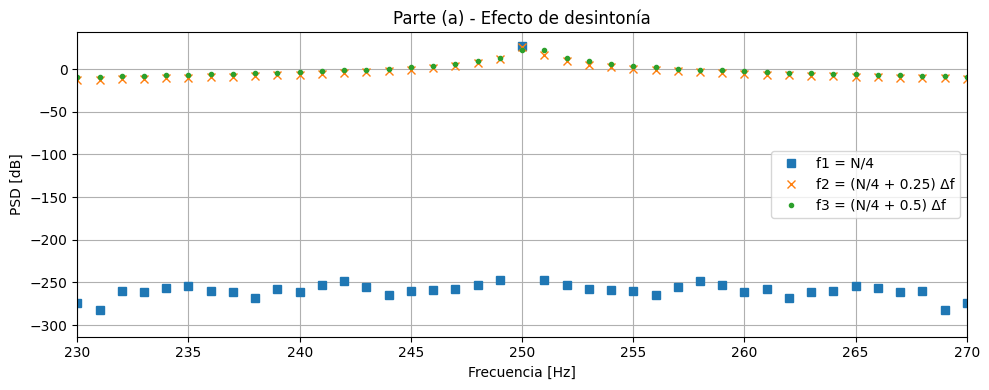

In [4]:
# ----------- FFT y PSD -----------
X1 = fft(x1)
PSD1 = (1 / N) * np.abs(X1) ** 2

X2 = fft(x2)
PSD2 = (1 / N) * np.abs(X2) ** 2

X3 = fft(x3)
PSD3 = (1 / N) * np.abs(X3) ** 2

ff_eje = np.arange(N) * delta_f

# ----------- Gráfico parte (a) -----------
plt.figure(figsize=(10, 4))
plt.plot(ff_eje, 10 * np.log10(PSD1), 's', label="f1 = N/4")
plt.plot(ff_eje, 10 * np.log10(PSD2), 'x', label="f2 = (N/4 + 0.25) Δf")
plt.plot(ff_eje, 10 * np.log10(PSD3), '.', label="f3 = (N/4 + 0.5) Δf")

plt.xlim([230, 270])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("Parte (a) - Efecto de desintonía")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Con el fin de simplificar la visualización y aprovechar la simetría de la DFT, se analiza únicamente hasta la frecuencia de Nyquist `fs/2`, ya que los bins superiores a esa frecuencia contienen información redundante para el análisis de las señales. 

De esta forma, para la señal alineada con frecuencia $f_1$, toda su energía aparece concentrada en un único bin, lo que se observa con un pico muy marcado en la PSD. Esto ocurre porque la frecuencia coincide exactamente con una frecuencia discreta de la DFT: la señal sinusoidal es coherente con la ventana rectangular de longitud `N` y no introduce componentes fuera del bin. 

En la señal de frecuencia $f_2$, que no coincide con un bin, la energía se distribuye entre varios bins y aparecen lóbulos laterales. Esto ocurre porque la DFT de una señal sinusoidal finita se comporta como una función `sinc`, con el lóbulo principal centrado en la frecuencia de la sinusoidal y lóbulos secundarios que decaen. Al no estar la frecuencia en un bin, la DFT muestrea esa `sinc` en puntos que no coinciden con su pico, por lo que la energía se reparte, dando lugar al fenómeno conocido como *spectral leakage* o desparramo espectral.

Por último, al situarse a medio bin, en la señal de frecuencia $f_3$ la energía se distribuye de manera distinta, tendiendo a repartirse casi simétricamente entre los dos bins adyacentes. De esta forma, en la PSD se observan dos picos de amplitud menor, con su suma de energías conservada, dando la apariencia de una doble cima o una mayor anchura aparente. 

La diferencia entre las distintas desintonías con respecto a $\Delta f$ puede transformar completamente la apariencia del espectro porque la DFT sólo observa las amplitudes en un conjunto discreto de frecuencias. La coherencia entre la señal y la ventana rectangular determina si la energía queda concentrada en un bin o si la envolvente `sinc` se evalúa entre bins, distribuyendo la energía entre ellos.  

---

A continuación, se buscó verificar la potencia unitaria de cada PSD utilizando la identidad de Parseval (3):


In [5]:
# Señal 1
energia_frec_1 = np.sum(PSD1)           #según Parseval
energia_tiempo_1 = np.sum(np.abs(x1)**2) #energía en tiempo

# Potencia unitaria
pot_frec_1 = energia_frec_1 /N       #dividir entre N para obtener potencia promedio
pot_tiempo_1 = energia_tiempo_1 /N

print("Señal 1:")
print(f"Potencia tiempo = {pot_tiempo_1:.3f}")
print(f"Potencia frecuencia = {pot_frec_1:.3f}")
print(f"Energía tiempo = {energia_tiempo_1:.3f}")
print(f"Energía frecuencia = {energia_frec_1:.3f}")
if np.isclose(energia_frec_1, energia_tiempo_1):
    print("Se cumple Parseval.")
print(" ")

# Señal 2
energia_frec_2 = np.sum(PSD2)
energia_tiempo_2 = np.sum(np.abs(x2)**2)
pot_frec_2 = energia_frec_2 /N
pot_tiempo_2 = energia_tiempo_2 /N

print("Señal 2:")
print(f"Potencia tiempo = {pot_tiempo_2:.3f}")
print(f"Potencia frecuencia = {pot_frec_2:.3f}")
print(f"Energía tiempo = {energia_tiempo_2:.3f}")
print(f"Energía frecuencia = {energia_frec_2:.3f}")
if np.isclose(energia_frec_2, energia_tiempo_2):
    print("Se cumple Parseval.")
print(" ")

# Señal 3
energia_frec_3 = np.sum(PSD3)
energia_tiempo_3 = np.sum(np.abs(x3)**2)
pot_frec_3 = energia_frec_3 /N
pot_tiempo_3 = energia_tiempo_3 /N

print("Señal 3:")
print(f"Potencia tiempo = {pot_tiempo_3:.3f}")
print(f"Potencia frecuencia = {pot_frec_3:.3f}")
print(f"Energía tiempo = {energia_tiempo_3:.3f}")
print(f"Energía frecuencia = {energia_frec_3:.3f}")
if np.isclose(energia_frec_3, energia_tiempo_3):
    print("Se cumple Parseval.")
print(" ")


Señal 1:
Potencia tiempo = 1.000
Potencia frecuencia = 1.000
Energía tiempo = 1000.000
Energía frecuencia = 1000.000
Se cumple Parseval.
 
Señal 2:
Potencia tiempo = 0.999
Potencia frecuencia = 0.999
Energía tiempo = 999.000
Energía frecuencia = 999.000
Se cumple Parseval.
 
Señal 3:
Potencia tiempo = 1.000
Potencia frecuencia = 1.000
Energía tiempo = 1000.000
Energía frecuencia = 1000.000
Se cumple Parseval.
 


Para comparar correctamente las señales en el dominio de la frecuencia, se trabaja con potencia unitaria. En este caso, tomar `amp = sqrt(2)` asegura que $P = 1$ para las señales generadas, por lo explicado en (5), tal como se observa en el código. 

La identidad de Parseval permite verificar que esta energía en el dominio temporal se conserva al pasar al dominio frecuencial. En el código, esto se comprueba calculando la energía directamente sobre la señal en el tiempo (`energia_tiempo_x`) y sobre la PSD obtenida de la DFT (`energia_frec_x`). La coincidencia entre ambos valores para las tres señales confirma que la DFT respeta la conservación de energía y que la PSD refleja correctamente la distribución de la potencia de la señal en función de la frecuencia. Incluso, se calcula la potencia de la PSD de las señales, confirmando su valor unitario. 

Este procedimiento también permite comparar señales desintonizadas, ya que la potencia total permanece constante, aunque su energía se distribuya en varios bins debido al desparramo espectral.

Observamos que dos señales que difieren apenas unos pocos hertz pueden mostrar espectros muy distintos al calcular la DFT. Esto ocurre porque la DFT mide componentes en frecuencias discretas $k \cdot \Delta f$. Si la señal sinusoidal tiene su frecuencia exactamente en un múltiplo de $\Delta f$, toda su energía se concentra en un solo bin (coherencia total). En cambio, si no está alineada, la ventana rectangular de duración $N$ “convoluciona” el espectro ideal de la sinusoidal (dos deltas en $ \pm f_0$) con la transformada de la ventana (una `sinc`), extendiendo la energía en frecuencia. El ancho del lóbulo principal de la sinc es inversamente proporcional a $N$; por eso, diferencias muy pequeñas de frecuencia respecto a $\Delta f$ implican muestrear esa envolvente en posiciones distintas, dando lugar a distribuciones muy diferentes entre bins. No obstante, de acuerdo con la identidad de Parseval, la potencia total de la señal se conserva: aunque visualmente los espectros parezcan muy diferentes (un único pico o varios lóbulos laterales), la suma de la energía en el dominio frecuencial sigue siendo la misma que en el dominio temporal, garantizando la consistencia del análisis.

---
Seguidamente, se repitió el cálculo de las DFT y PSD aplicando la técnica de zero padding:

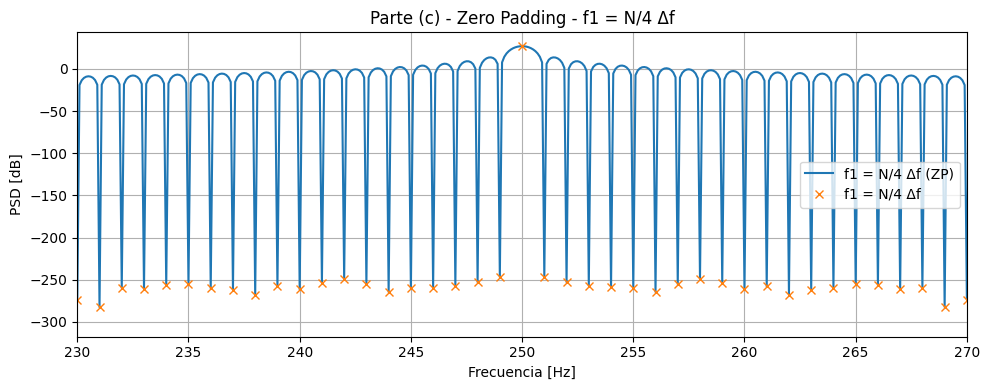

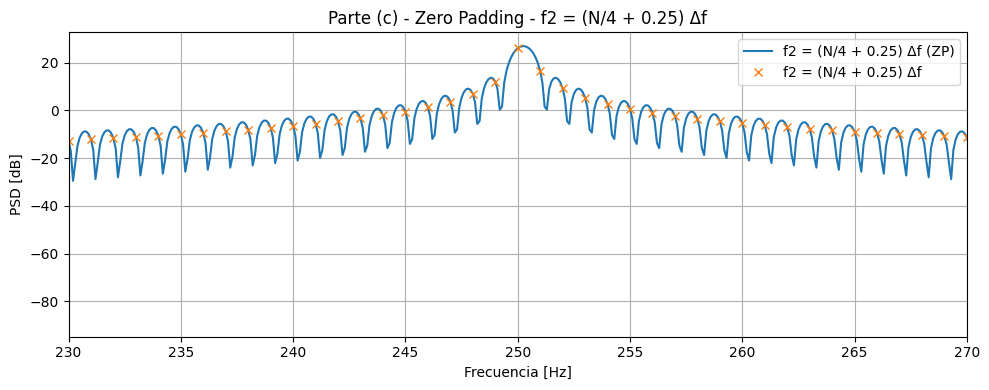

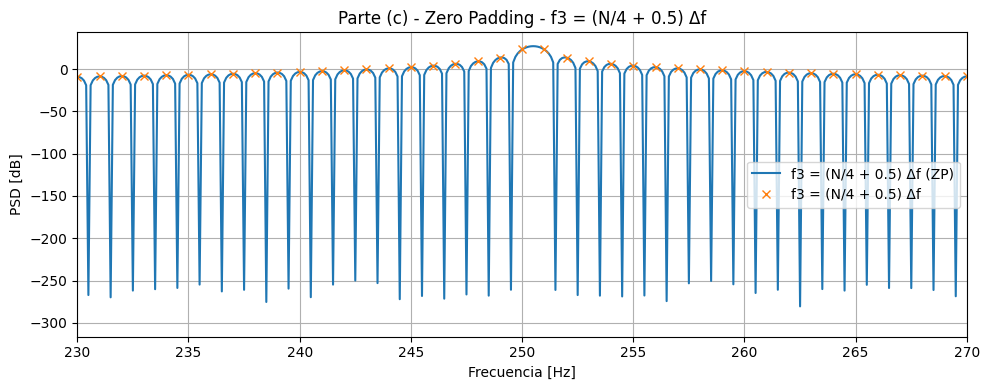

In [13]:
Npad = 10*N   #señal extendida con 9N ceros

def zero_padding_fft(x, Npad, fs):
    x_pad = np.zeros(Npad)
    x_pad[:len(x)] = x
    X_pad = fft(x_pad)
    PSD_pad = (1/len(x))*np.abs(X_pad)**2   #normalizo por N original
    ff_pad = np.arange(Npad)*fs/Npad
    return ff_pad, PSD_pad

ff1_pad, PSD1_pad = zero_padding_fft(x1, Npad, fs)
ff2_pad, PSD2_pad = zero_padding_fft(x2, Npad, fs)
ff3_pad, PSD3_pad = zero_padding_fft(x3, Npad, fs)

plt.figure(figsize=(10,4))
plt.plot(ff1_pad, 10*np.log10(PSD1_pad), label="f1 = N/4 Δf (ZP)")
plt.plot(ff_eje, 10*np.log10(PSD1), 'x', label="f1 = N/4 Δf")
plt.xlim([230, 270])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("Parte (c) - Zero Padding - f1 = N/4 Δf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(ff2_pad, 10*np.log10(PSD2_pad), label="f2 = (N/4 + 0.25) Δf (ZP)")
plt.plot(ff_eje, 10*np.log10(PSD2), 'x', label="f2 = (N/4 + 0.25) Δf")
plt.xlim([230, 270])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("Parte (c) - Zero Padding - f2 = (N/4 + 0.25) Δf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(ff3_pad, 10*np.log10(PSD3_pad), label="f3 = (N/4 + 0.5) Δf (ZP)")
plt.plot(ff_eje, 10*np.log10(PSD3), 'x', label="f3 = (N/4 + 0.5) Δf")
plt.xlim([230, 270])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("Parte (c) - Zero Padding - f3 = (N/4 + 0.5) Δf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En la función `zero_padding_fft` se crea un vector de `Npad = 10*N` ceros y se copia la señal original en las primeras `N` posiciones, agregando así `9*N` ceros al final. Se calcula, luego, la DFT y la PSD de la nueva señal `x_pad` y se define un nuevo eje de frecuencias `ff_pad` que tiene pasos más finos de frecuencia `fs/Npad`. Se observa que la técnica del zero padding no cambia la información temporal de la señal, sólo interpola la DFT, aumentando su longitud y agregando más puntos en el eje de frecuencia. 

De esta forma, para la señal de frecuencia $f_1$, al aplicar zero padding se observa que el pico aparece interpolado, pero sigue estando exactamente centrado. Como la frecuencia está alineada con un bin de la DFT, toda la energía de la señal está concentrada en él, por lo que no hay desparramo espectral y la función sinc interpolante se extiende a lo largo del espectro, decayendo lentamente hacia los bins adyacentes. Esto hace que los lóbulos laterales lleguen prácticamente hasta el piso de ruido, aunque la energía real permanece concentrada en el bin central. Por lo tanto, el zero padding no crea nueva información, sino que permite visualizar la interpolación continua de la DFT con mayor resolución en frecuencia.

En relación a la señal de frecuencia $f_2$, esta misma no coincide exactamente con un bin de la DFT. Como resultado, al calcular la DFT original se observa desparramo espectral, ya que la energía de la señal se distribuye entre varios bins. Al aplicar zero padding, la función `sinc` interpolante aparece con mayor definición, lo que permite identificar mejor la posición real del máximo, que se ubica entre dos bins. Sin embargo, la energía sigue estando repartida y no concentrada en un único bin, por lo que el leakage no desaparece: simplemente se representa de manera más suave y detallada.

En el caso de $f_3$, la frecuencia está todavía más desalineada respecto a los bins de la DFT, por lo que la energía de la señal se reparte entre varios bins, mostrando un mayor desparramo espectral. Al aplicar zero padding, el máximo del lóbulo principal de la función `sinc` interpolante se ubica entre los dos bins adyacentes donde se distribuye la energía. Los lóbulos laterales de la `sinc` decaen lentamente, llegando prácticamente hasta el piso de ruido de la señal con frecuencia $f_1$, aunque la energía real sigue concentrada principalmente alrededor del pico.

A diferencia de $f_1$, donde el máximo del lóbulo principal de la sinc coincide exactamente con un bin y sus mínimos se alinean con los demás bins de la malla de frecuencias, en el caso de $f_3$ esos mínimos ya no coinciden con los bins. En su lugar, los bins caen en posiciones donde la sinc aún tiene amplitud significativa, a menudo cerca de los máximos de los lóbulos laterales. Como resultado, la DFT asigna energía a un gran número de bins y el espectro aparenta decaer lentamente hasta niveles muy bajos.

Esto ilustra que el zero padding no concentra energía ni mejora la resolución real, sino que muestra la interpolación continua de la DFT con mayor definición en frecuencia.

### Bonus
Para finalizar, se buscó calcular la respuesta en frecuencia de los tres sistemas LTI analizados en la TS2.  Se analizó en primer lugar el sistema definido por la ecuación:
$$
y[n] = 3 \cdot 10^{-2} \cdot x[n] + 5 \cdot 10^{-2} \cdot x[n-1] + 3 \cdot 10^{-2} \cdot x[n-2] + 1.5 \cdot y[n-1] - 0.5 \cdot y[n-2]
$$

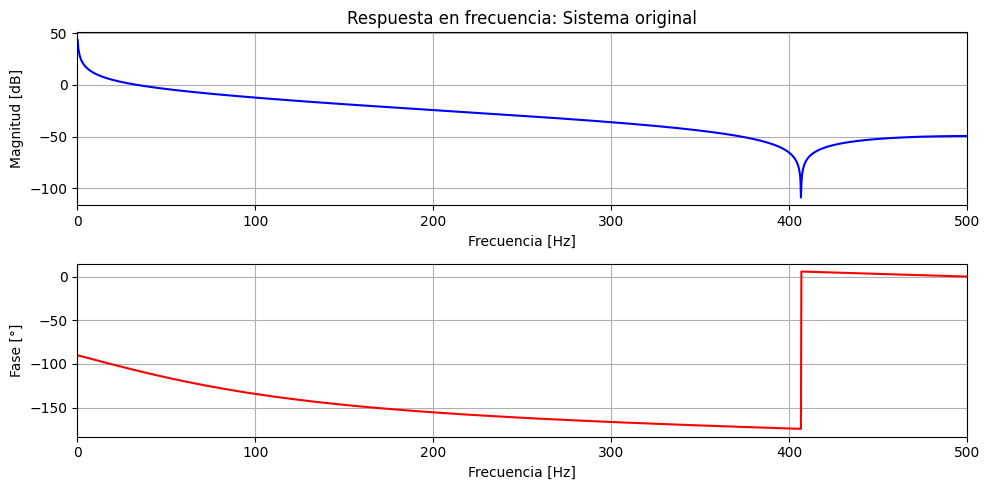

In [25]:
#Respuesta en frecuencia

def plot_frec_respuesta(b, a, fs, titulo='Sistema LTI'):
    w, h = freqz(b, a, worN=2048)  #2048 puntos para buena resolución
    f = w * fs / (2*np.pi)          #Convertir de rad/muestra a Hz
    
    plt.figure(figsize=(10,5))
    
    # Magnitud
    plt.subplot(2,1,1)
    plt.plot(f, 20*np.log10(np.abs(h)), 'b')
    plt.title(f'Respuesta en frecuencia: {titulo}')
    plt.ylabel('Magnitud [dB]')
    plt.xlabel('Frecuencia [Hz]')
    plt.xlim(0,500)
    plt.grid(True)
    
    # Fase
    plt.subplot(2,1,2)
    plt.plot(f, np.angle(h, deg=True), 'r')
    plt.xlabel('Frecuencia [Hz]')
    plt.xlim(0,500)
    plt.ylabel('Fase [°]')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# 1) Sistema original (b, a)

b = np.array([0.03, 0.05, 0.03])    #Entrada x
a = np.array([1, -1.5, 0.5])        #Salida y (muevo hacia el otro lado)

plot_frec_respuesta(b, a, fs, 'Sistema original')

La función `plot_frec_respuesta` calcula la respuesta en frecuencia (4) de un sistema LTI utilizando `scipy.signal.freqz`. Esta función toma los coeficientes $b$ y $a$ de la ecuación de diferencias que describe el sistema LTI y evalúa $H(e^{j\omega})$ directamente usando la definición:
$$
H(e^{j\omega}) = \frac{Y(e^{j\omega})}{X(e^{j\omega})} = \frac{b_0 + b_1 e^{-j \omega} + \dots + b_M e^{-j M \omega}}{1 + a_1 e^{-j \omega} + \dots + a_N e^{-j N \omega}}
$$

Y devuelve:

 - `w`: el vector de frecuencias (en radianes por muestra).
 - `h`: los valores complejos de la respuesta en frecuencia $H(e^{j\omega})$.
   
Con lo que se puede obtener la magnitud $|H(e^{j\omega})|$, que dice cuánto amplifica o atenúa cada frecuencia, y la fase $\arg(H(e^{j\omega}))$, que indica el desfase introducido.

En la respuesta en frecuencia del sistema analizado se observa un comportamiento característico de filtro pasabajos con un mínimo pronunciado. La magnitud presenta una atenuación progresiva a medida que aumenta la frecuencia, pero alrededor de los 400 Hz se identifica un mínimo extremadamente marcado donde la magnitud cae aproximadamente 150 dB, indicando la presencia de un cero de transmisión en esa banda de frecuencia. Este cero produce una atenuación casi completa de las componentes espectrales alrededor de los 400 Hz. Respecto a la fase, exhibe una variación negativa y aproximadamente lineal con la frecuencia, característica de sistemas con retardo de grupo constante, excepto en la región del mínimo donde se produce una discontinuidad de fase de 180°, fenómeno típico asociado a ceros cercanos al círculo unitario. Globalmente, el sistema funciona como un filtro que preserva las bajas frecuencias, rechaza selectivamente una banda estrecha alrededor de 400 Hz y atenúa gradualmente las componentes de alta frecuencia.

Luego, para el sistema descripto por la ecuación $y[n] = x[n] + 3 \cdot x[n-10]$:

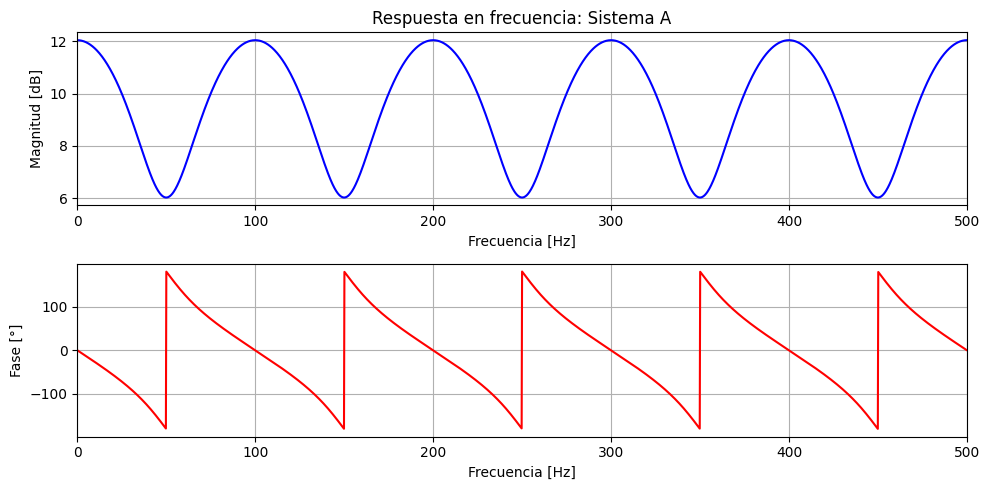

In [27]:
# 2) Sistema A: y[n] = x[n] + 3 x[n-10]
# H_A(z) = 1 + 3 z^-10
hA = np.zeros(N)  #respuesta al impulso sistema A
hA[0] = 1
if 10 < N:
    hA[10] = 3      #Hay salida 1 en n=0 y 3 en n=10  (necesito delta[0])
    
bA = hA[:10+1]   # coeficientes no nulos de hA
aA = [1]
plot_frec_respuesta(bA, aA, fs, 'Sistema A')

El sistema A, siendo un filtro FIR con un impulso en `n = 0` y otro en `n = 10`, exhibe una respuesta en frecuencia con características periódicas y ondulatorias debido a su naturaleza de fase lineal y su estructura de retardos. La magnitud muestra un patrón de múltiples lóbulos y ceros periódicos, típico de los filtros de tipo "peine". Los ceros de transmisión aparecen a frecuencias donde la suma de las componentes retardadas se cancela, resultando en atenuaciones profundas. La fase, por su parte, es lineal por segmentos con discontinuidades de `180°` en las frecuencias de los ceros, lo que es consistente con sistemas FIR de fase lineal. Este sistema actúa como un ecualizador o filtro de peine, enfatizando y atenuando bandas específicas de manera periódica.

Finalmente, para el sistema descripto por la ecuación $y[n] = x[n] + 3 \cdot y[n-10]$:

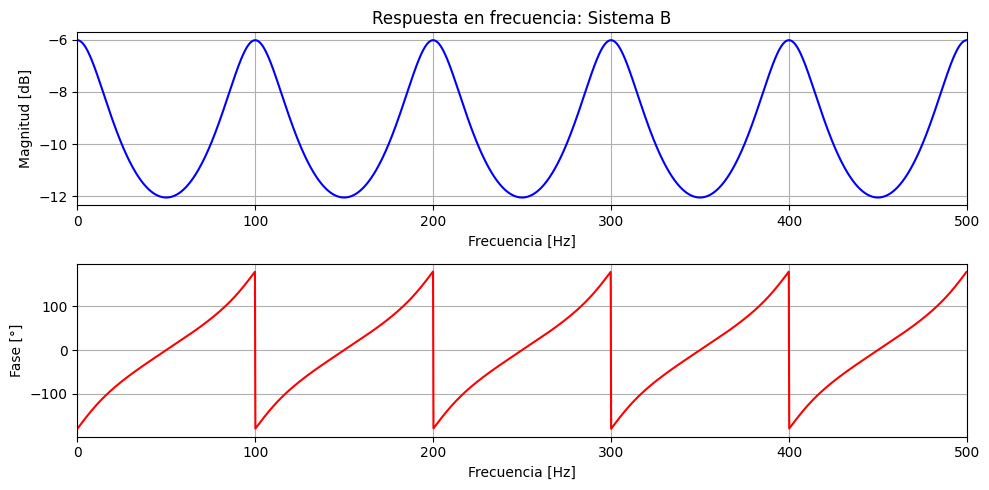

In [28]:
# 3) Sistema B: y[n] = x[n] + 3 y[n-10]
# bB y aB ya definidos
bB = [1]
aB = np.zeros(10+1)
aB[0] = 1
aB[10] = -3

plot_frec_respuesta(bB, aB, fs, 'Sistema B')

El sistema B exhibe una respuesta en frecuencia con picos resonantes periódicos debido a la realimentación positiva a 10 retardos. La magnitud muestra múltiples picos estrechos y agudos a intervalos regulares de frecuencia, aproximadamente cada $\frac{f_s}{10} = 50 \, \text{Hz}$ (para $f_s = 500 \, \text{Hz}$), lo que indica la presencia de polos cercanos al círculo unitario en el plano Z. Estos picos resonantes corresponden a frecuencias donde el denominador de la función de transferencia se acerca a cero, amplificando selectivamente esas bandas. Entre los picos, se observan valles de atenuación donde la magnitud cae abruptamente. La fase presenta discontinuidades de 180° en las frecuencias resonantes, acompañadas de cambios bruscos en la pendiente, típicos de sistemas IIR con polos dominantes. Este comportamiento es característico de un filtro de peine recursivo, que genera un efecto de "eco" y resuena armónicamente a múltiplos de la frecuencia fundamental asociada al retardo.

La diferencia fundamental en el comportamiento de la fase entre el sistema A (FIR) y el sistema B (IIR) radica en la naturaleza opuesta de sus funciones de transferencia. El sistema A, al ser un filtro FIR con retardos puros
$$
H_A (z) = 1 + 3z^{-10}
$$
introduce un retardo de fase constante y negativo debido al término $z^{-10}$, lo que se manifiesta como una pendiente descendente en la respuesta de fase, con discontinuidades de $-180°$ en las frecuencias donde ocurren ceros de transmisión. Por el contrario, el sistema B, al ser un filtro IIR con realimentación positiva inestable
$$
H_B (z) = \frac{1}{1-3z^{-10}}
$$
posee polos fuera del círculo unitario que generan un avance de fase (pendiente positiva) cerca de las frecuencias resonantes, acompañado de saltos de $+180°$ en las mismas. Así, mientras el FIR "retrasa" la fase de manera predecible, el IIR inestable la "adelanta" abruptamente en bandas específicas, creando perfiles opuestos que reflejan la dualidad entre sistemas de fase mínima (FIR) y sistemas no mínimos (IIR inestables).

## Conclusión
El trabajo desarrollado permitió no solo comprender el fenómeno del desparramo espectral que surge al aplicar la Transformada Discreta de Fourier, sino también analizar en detalle sus implicancias prácticas en el procesamiento digital de señales. Se demostró que la ubicación de la frecuencia de una señal sinusoidal respecto a los bins de la DFT es determinante: cuando la frecuencia coincide con un múltiplo exacto de la separación en frecuencia, la energía se concentra en un único coeficiente; mientras que, al existir una mínima desintonía, la energía se reparte en varios bins y se generan lóbulos laterales que distorsionan la visualización del espectro. Este efecto, conocido como spectral leakage, evidencia los límites de la DFT en escenarios donde la señal no es coherente con la ventana de análisis.

Asimismo, a través de la verificación del teorema de Parseval, se confirmó que la energía de la señal se conserva al pasar del dominio temporal al frecuencial, lo que brinda una base sólida para interpretar las representaciones espectrales y validar la correcta estimación de la densidad espectral de potencia. El uso de senoidales normalizadas en potencia permitió realizar comparaciones justas entre señales alineadas y desalineadas, mostrando que, si bien el aspecto visual del espectro cambia drásticamente, la energía total permanece inalterada.

Otro aspecto relevante fue la aplicación de la técnica de zero padding, que se mostró como una herramienta eficaz para mejorar la resolución en frecuencia de la DFT. Si bien no incrementa la información real contenida en la señal ni concentra la energía, esta técnica facilita la visualización detallada del comportamiento de la envolvente sinc, permitiendo localizar con mayor precisión la frecuencia de la señal y comprender mejor la forma de los lóbulos asociados al leakage.

Finalmente, la extensión del análisis al estudio de sistemas lineales e invariantes en el tiempo (LTI) permitió observar cómo distintas estructuras procesan las componentes espectrales de una señal. Se distinguieron comportamientos típicos de filtros FIR e IIR: desde la atenuación progresiva de altas frecuencias en filtros pasabajos hasta los patrones periódicos de los filtros de peine y los picos resonantes de sistemas con realimentación. Esto puso en evidencia la estrecha relación entre la teoría de la DFT, la caracterización espectral de señales y la respuesta en frecuencia de los sistemas, integrando conceptos trabajados en diferentes instancias de la materia.

## Reflexión personal

En la realización de este trabajo pude comprender en mayor profundidad el funcionamiento de la Transformada Discreta de Fourier y, sobre todo, la importancia de interpretar correctamente sus resultados. Antes de hacerlo, tenía una idea más abstracta de lo que significaba el espectro de una señal; ahora, en cambio, entendí que detalles tan pequeños como que la frecuencia esté o no alineada con los bins de la DFT pueden cambiar completamente la forma en que se ve el espectro, aunque la energía de la señal siga siendo la misma.

Aprendí también que el fenómeno del desparramo espectral no es un error de la herramienta, sino una consecuencia natural de trabajar con ventanas finitas de tiempo, lo que me permitió valorar el rol que cumplen conceptos como Parseval para confirmar que la energía se conserva, más allá de cómo se distribuya. La técnica de zero padding me resultó muy interesante porque, si bien no aporta información nueva, me ayudó a visualizar con más claridad cómo se comporta la sinc y cómo se reparte la energía en frecuencia.

Con el objetivo de profundizar en los contenidos teóricos recurrí a la bibliografía recomendada (*Thomas Holton - Digital Signal Processing*) y a las documentaciones de las funciones empleadas en el código, como `fft` o `freqz`. Además, utilicé ChatGPT para consultar algunos comandos de Python y reforzar los contenidos teóricos, lo que me permitió obtener explicaciones más claras y analizar con mayor seguridad los resultados obtenidos.